# Reproduzindo o Visconde

Elton Cardoso do Nascimento - 233840

> - Reproduzir o Visconde
> - Buscador: BM25 (pyserini) ou um sentence-transformer
> - Geração: LLaMa 3 70B (groq)
> - Avaliação no IIRC (F1, exact_match) usar 10% (150 primeiras perguntas.)
> - Pedir resultado do LLM em JSON para facilitar a avaliação automática
> - Usar exact match e F1-bow como métricas de avaliação
> - Usem o código do Visconde como referência: https://github.com/neuralmind-ai/visconde/
> - Ao indexar a base de busca, indexem apenas os documentos que são utilizados pelas 150 primeiras perguntas. Procurem pela key "links". Observem que o uso de segmentação é necessário. Tentei usar slding window baseado nas sentenças. Uma janela com 5 sentenças e 1 ou 2 de overlap é interessante. Podem experimentar outros valores, se houver tempo. Procurem no código do visconde o trecho onde o janelamento é feito e usem como base.
> - Para fazer os exemplos few-shot usem o autocot (ver slides)

In [36]:
import os
import json
import time
import threading
import unicodedata
import collections
import string
import re
from typing import Optional


import pyserini
from pyserini.search import SimpleSearcher
import tqdm
import torch #spacy não carrega sem importar antes (??)
import spacy
import groq
import numpy as np
import matplotlib.pyplot as plt

# Carregando o Dataset

In [2]:
if not os.path.isfile("iirc_test.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json
    
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/context_articles.tar.gz
    !tar -xf context_articles.tar.gz

In [3]:
file = open("iirc_test.json", "r")
test_data = json.load(file)
file.close()

file = open("context_articles.json", "r")
articles = json.load(file)
file.close()

In [4]:
test_data[0]["links"]

[{'target': 'Sicily', 'indices': [68, 76]},
 {'target': 'Chthonic', 'indices': [77, 85]},
 {'target': 'Roman mythology', 'indices': [97, 112]},
 {'target': 'Greek mythology', 'indices': [140, 155]},
 {'target': 'Ovid', 'indices': [179, 183]},
 {'target': 'Virgil', 'indices': [215, 221]},
 {'target': 'Palagonia', 'indices': [319, 328]},
 {'target': 'Geyser', 'indices': [393, 400]},
 {'target': 'Zeus', 'indices': [706, 710]},
 {'target': 'Hephaestus', 'indices': [724, 734]},
 {'target': 'Aetna (nymph)', 'indices': [739, 744]},
 {'target': 'Thalia (nymph)', 'indices': [748, 754]},
 {'target': 'Adranus', 'indices': [828, 835]}]

In [5]:
articles["sicily"]

'Sicily ( ; ) is the <a href="List%20of%20islands%20in%20the%20Mediterranean">largest island</a> in the <a href="Mediterranean%20Sea">Mediterranean Sea</a> and one of the 20 <a href="Regions%20of%20Italy">regions</a> of <a href="Italy">Italy</a>. It is one of the five Italian <a href="Regions%20of%20Italy%23Autonomous%20regions%20with%20special%20statute">autonomous regions</a>, in <a href="Southern%20Italy">Southern Italy</a> along with surrounding minor islands, officially referred to as <i>Regione Siciliana</i>.\n\nSicily is located in the central Mediterranean Sea, south of the <a href="Italian%20Peninsula">Italian Peninsula</a>, from which it is separated by the narrow <a href="Strait%20of%20Messina">Strait of Messina</a>. Its most prominent landmark is <a href="Mount%20Etna">Mount Etna</a>, the tallest active volcano in Europe, and one of the most active in the world, currently 3329 m high. The island has a typical <a href="Mediterranean%20climate">Mediterranean climate</a>.\n\nT

In [6]:
test_data[0]

{'questions': [{'answer': {'type': 'span',
    'answer_spans': [{'text': 'sky and thunder god',
      'passage': 'zeus',
      'type': 'answer',
      'start': 83,
      'end': 102}]},
   'question': 'What is Zeus know for in Greek mythology?',
   'context': [{'text': 'he Palici the sons of Zeus',
     'passage': 'main',
     'indices': [684, 710]},
    {'text': 'in Greek mythology', 'passage': 'main', 'indices': [137, 155]},
    {'text': 'Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion',
     'passage': 'Zeus',
     'indices': [0, 110]}],
   'question_links': ['Greek mythology', 'Zeus']}],
 'text': "The Palici (Παλικοί in Greek), or Palaci, were a pair of indigenous Sicilian chthonic deities in Roman mythology, and to a lesser extent in Greek mythology. They are mentioned in Ovid's Metamorphoses V, 406, and in Virgil's Aeneid IX, 585. Their cult centered on three small lakes that emitted sulphurous vapors in the Palagonia 

Carrega os documentos que estão linkados as questões

In [7]:
n_question = 1

In [8]:
documents = []
all_titles = []

documents_not_found = []

for i in range(n_question):
    item = test_data[i]
    if item['title'].lower() not in all_titles:
        documents.append({
                "title": item['title'],
                "content": item["text"]
            }
        )
        all_titles.append(item['title'].lower())
    for link in item["links"]:
        if link['target'].lower() in articles and link['target'].lower() not in all_titles:
            documents.append({
                "title": link['target'],
                "content": articles[link['target'].lower()]
            })
            all_titles.append(link['target'].lower())
        else:
            documents_not_found.append(link["target"].lower())

In [9]:
documents_not_found

[]

Transforma os documentos em chunks

In [10]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

#12345
#   45678
stride = 3#2
max_length = 5#3

def window(documents, stride, max_length):
    treated_documents = []

    for j,document in enumerate(tqdm.tqdm(documents)):
        doc_text = document['content']
        doc = nlp(doc_text[:10000])
        sentences = [sent.text.strip() for sent in doc.sents]
        for i in range(0, len(sentences), stride):
            segment = ' '.join(sentences[i:i + max_length])
            treated_documents.append({
                "title": document['title'],
                "contents": document['title']+". "+segment,
                "segment": segment
            })
            if i + max_length >= len(sentences):
                break
    return treated_documents

treated_documents = window(documents, stride, max_length)

100%|██████████| 14/14 [00:00<00:00, 60.87it/s]


Cria o índice

In [11]:
if not os.path.isdir("data"):
    !mkdir data

if not os.path.isdir("data\iirc_indices"):
    !mkdir data\iirc_indices

In [12]:
file = open("data/iirc_indices/contents.jsonl",'w')

for i, doc in enumerate(treated_documents):
    doc['id'] = i
    if doc['segment'] != "":
        file.write(json.dumps(doc)+"\n")

In [13]:
!python -m pyserini.index -collection JsonCollection -generator DefaultLuceneDocumentGenerator -threads 1 -input data/iirc_indices -index data/iirc_index -storeRaw

pyserini.index is deprecated, please use pyserini.index.lucene.
2024-05-08 22:12:14,159 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2024-05-08 22:12:14,161 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2024-05-08 22:12:14,161 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2024-05-08 22:12:14,162 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: data/iirc_indices
2024-05-08 22:12:14,162 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2024-05-08 22:12:14,162 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2024-05-08 22:12:14,162 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 1
2024-05-08 22:12:14,162 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en


Organiza as questões

In [14]:
all_q = []

for i in range(n_question):
    item = test_data[i]
    for q in item['questions']:
        q['text'] = item['text']
        q['title'] = item['title']
        q['links'] = item['links']
        all_q.append(q)

# Prompt

Prepara o prompt one-shot

In [15]:
base_prompt = '''
You must answer a question using documents as reference to create your answer.

Example:

Query
{
"documents:" List of documents you NEED to use to answer the question,

"question": question you need to answer.
}

Response
{
"evidence": your reasoning, USING THE DOCUMENTS, to answer the question. You MUST cite a document as [Document i], example: 'According to [Document 5], ...',

"answer": your final few words or number answer.
}

Your turn:

Query
'''

Procura os documentos relacionados a questão e prepara o prompt para a questão

In [16]:
searcher = SimpleSearcher("./data/iirc_index")

SimpleSearcher class has been deprecated, please use LuceneSearcher from pyserini.search.lucene instead


In [17]:
search_result = searcher.search(all_q[0]["question"], k=20)

In [18]:
question_documents = []
for result in search_result:
    result = json.loads(result.raw)

    question_documents.append(result["segment"])

Rerank com BERT (não é o modelo ideal)

In [19]:
bert_tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.enable_grad(False)
bert.to(device)
bert.eval();

Using cache found in C:\Users\eltsu/.cache\torch\hub\huggingface_pytorch-transformers_main
Using cache found in C:\Users\eltsu/.cache\torch\hub\huggingface_pytorch-transformers_main


In [20]:
tokens = bert_tokenizer(question_documents, return_tensors="pt", #Return as torch tensor 
                                 padding=True, #Add padding to small sequences
                                 return_token_type_ids=False, #Don't return sequence mask (only one sequence)
                                 truncation=True) #Truncate big sentences (max = 512 tokens, with CLS and SEP)

input_ids = tokens["input_ids"].to(device)
attention_mask = tokens["attention_mask"].to(device)

result = bert(input_ids = input_ids, attention_mask=attention_mask)


In [21]:
tokens_question = bert_tokenizer(all_q[0]["question"], return_tensors="pt", #Return as torch tensor 
                                 padding=True, #Add padding to small sequences
                                 return_token_type_ids=False, #Don't return sequence mask (only one sequence)
                                 truncation=True) #Truncate big sentences (max = 512 tokens, with CLS and SEP)

input_ids = tokens_question["input_ids"].to(device)
attention_mask = tokens_question["attention_mask"].to(device)

result_question = bert(input_ids = input_ids, attention_mask=attention_mask)

In [22]:
document_vectors = result["last_hidden_state"][:,0]
question_vectors = result_question["last_hidden_state"][:,0]

In [23]:
document_vectors_norm = torch.nn.functional.normalize(document_vectors)
question_vectors_norm = torch.nn.functional.normalize(question_vectors)

question_cosine_similarity = document_vectors_norm @ question_vectors_norm.T  #[question_index, document_index]

In [26]:
del result, result_question, document_vectors, question_vectors, tokens, tokens_question

In [27]:
question_cosine_similarity.flatten()

tensor([0.9155, 0.9165, 0.9274, 0.9116, 0.9038, 0.8798, 0.8781, 0.8778, 0.8920,
        0.9253, 0.8568, 0.9069, 0.8650, 0.9203, 0.8910, 0.9139, 0.9095, 0.9007,
        0.9261, 0.9186], device='cuda:0', grad_fn=<ViewBackward0>)

<BarContainer object of 20 artists>

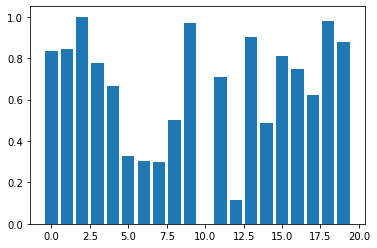

In [35]:
height = (question_cosine_similarity-question_cosine_similarity.min()) / (question_cosine_similarity.max()-question_cosine_similarity.min())
height = height.detach().cpu().numpy().flatten()

plt.bar(x = range(height.shape[0]), 
        height=height)

In [52]:
_, top_k = torch.topk(question_cosine_similarity.flatten(), 10)

top_k = top_k.detach().cpu().numpy()

reranked_q_documents = np.array(question_documents)[top_k]

In [55]:
question_query = {"documents":question_documents, "question":all_q[0]["question"]} 

In [56]:
prompt = base_prompt + str(question_query) + "\n\n" + "Response\n"

# Inferência

Realiza a inferência com o Groq

In [58]:
class GroqInterface:
    '''
    Interface for using the Groq API

    Implements a rate limit control for multi-threading use. 
    '''

    _client = None 

    LLAMA3_70B = "llama3-70b-8192"

    rate_lock = threading.Lock()
    SINGLE_THREAD = True

    def __init__(self, model:Optional[str]=None, api_key=None, json_mode=False, system_message=None):
        '''
        GroqInterface constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
        '''
        
        if GroqInterface._client is None:

            if api_key is None:
                api_key = os.environ.get("GROQ_API_KEY")

            if api_key is None:
                raise RuntimeError("API key is not in the environment variables ('GROQ_API_KEY' variable is not set).")

            GroqInterface._client = groq.Groq(api_key=api_key)

        if model is None:
            model = GroqInterface.LLAMA3_70B
        self._model = model

        self._system_message = system_message


        if json_mode:
            self._response_format = {"type": "json_object"}
        else:
            self._response_format = None
        self._json_mode = json_mode

    def __call__(self, prompt:str) -> str:
        '''
        Generates the model response

        Args:
            prompt (str): prompt to send to the model.

        Returns:
            str: model response. 
        '''
        done = False
        while not done:

            try:
                if not GroqInterface.SINGLE_THREAD:
                    GroqInterface.rate_lock.acquire()
                    GroqInterface.rate_lock.release()

                messages = []
                if self._system_message is not None:
                    messages.append({"role":"system", "content":self._system_message})
                
                messages.append({"role":"user", "content":prompt})

                chat_completion = GroqInterface._client.chat.completions.create(
                        messages=messages,
                        model=self._model,
                        response_format=self._response_format
                    )
                
                done = True
            except groq.RateLimitError as exception:
                print("ERROR")
                GroqInterface.error = exception
                if not GroqInterface.SINGLE_THREAD:
                    if not GroqInterface.rate_lock.locked():
                        GroqInterface.rate_lock.acquire()
                        time.sleep(2)
                        GroqInterface.rate_lock.release()
                else:
                    time.sleep(2)

        return chat_completion.choices[0].message.content

Mensagem do sistema para saída em JSON

In [59]:
system_message = "You are a question answer assistant that outputs in JSON.\n The JSON object must use the schema: {'evidence':'string', 'answer':'string'}"

In [60]:
groq_interface = GroqInterface(api_key="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", json_mode=True, system_message=system_message)

In [61]:
answer = groq_interface(prompt)

In [62]:
answer_parsed = json.loads(answer)
answer_parsed

{'evidence': "According to Document 8, 'Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion, who rules as king of the gods of Mount Olympus.', and Document 11, 'Zeus is the only deity in the Olympic pantheon whose name has such a transparent Indo-European etymology.', Zeus is known as the king of the gods and the god of the sky and thunder in Greek mythology. As stated in Document 10, 'He decided to wipe out mankind and flooded the world with the help of his brother Poseidon.', Zeus has also been depicted as using violence to get his way and terrorize humans.",
 'answer': 'Zeus is known as the king of the gods and the god of the sky and thunder in Greek mythology.'}

In [63]:
all_q[0]["answer"]

{'type': 'span',
 'answer_spans': [{'text': 'sky and thunder god',
   'passage': 'zeus',
   'type': 'answer',
   'start': 83,
   'end': 102}]}

In [64]:
all_q[0]["question"]

'What is Zeus know for in Greek mythology?'

# Métrica

Calcula scores da resposta

In [65]:
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  def remove_accents(input_str):
      nfkd_form = unicodedata.normalize('NFKD', input_str)
      only_ascii = nfkd_form.encode('ASCII', 'ignore')
      return only_ascii.decode("utf-8")

  return white_space_fix(remove_articles(remove_punc(lower(remove_accents(s)))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

In [66]:
a_gold = all_q[0]["answer"]["answer_spans"][0]["text"]
a_pred = answer_parsed["answer"]

In [67]:
compute_f1(a_gold, a_pred)

0.4

In [68]:
compute_exact(a_gold, a_pred)

0